In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

In [2]:
df = pd.read_csv("merged_data.csv")
df["date"] = pd.to_datetime(df.date, format="%Y%m%d")

In [3]:
def plot_log_returns(df, tickers):
    ncols = 2
    nrows = len(tickers) // ncols if len(tickers) % ncols == 0 else len(tickers) // ncols + 1
    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7))
    for idx, ticker in enumerate(tickers):
        returns = df.loc[df.ticker == ticker, ["date", "log_return"]]
        cur_ax = ax[idx // ncols][idx % ncols]
        sns.lineplot(data=returns, x="date", y="log_return", ax=cur_ax)
        cur_ax.set_title(ticker)
    plt.tight_layout()

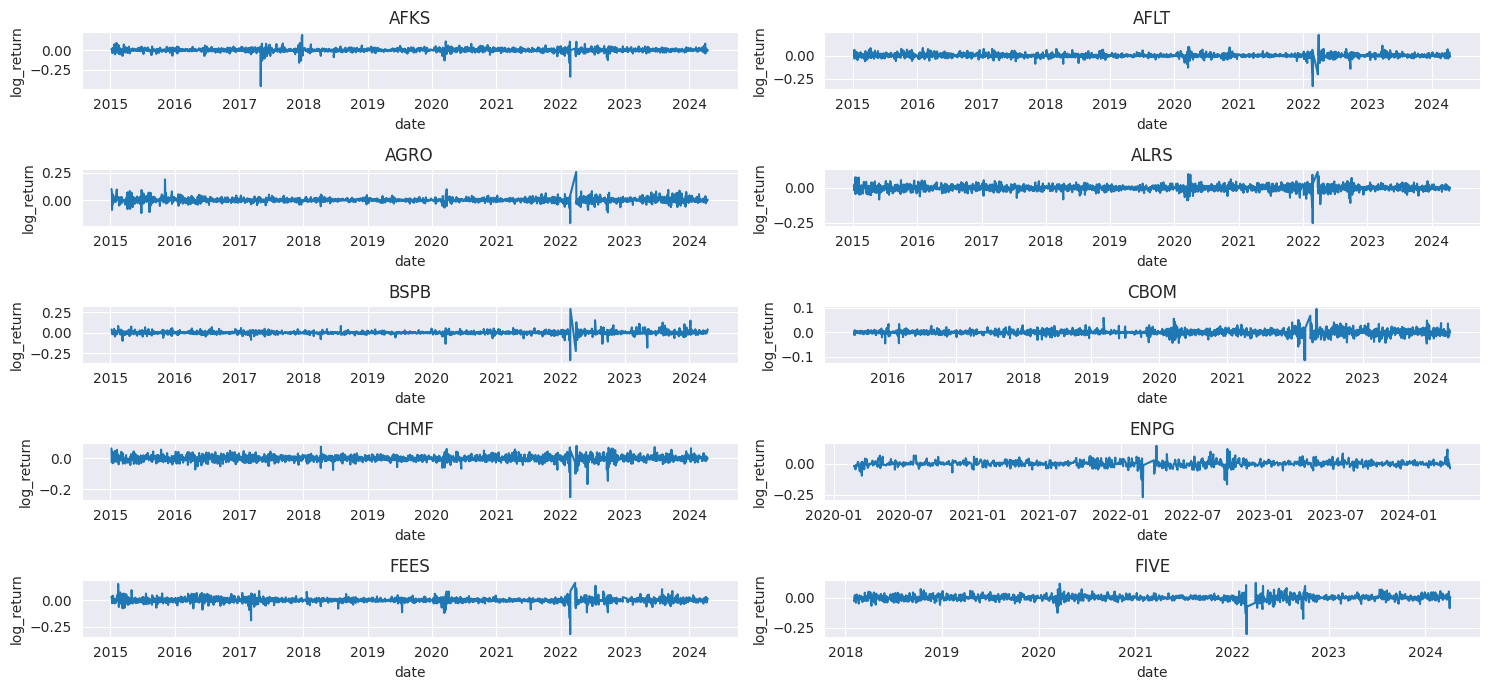

In [4]:
tickers = df.ticker.unique()
plot_log_returns(df, tickers[:10])

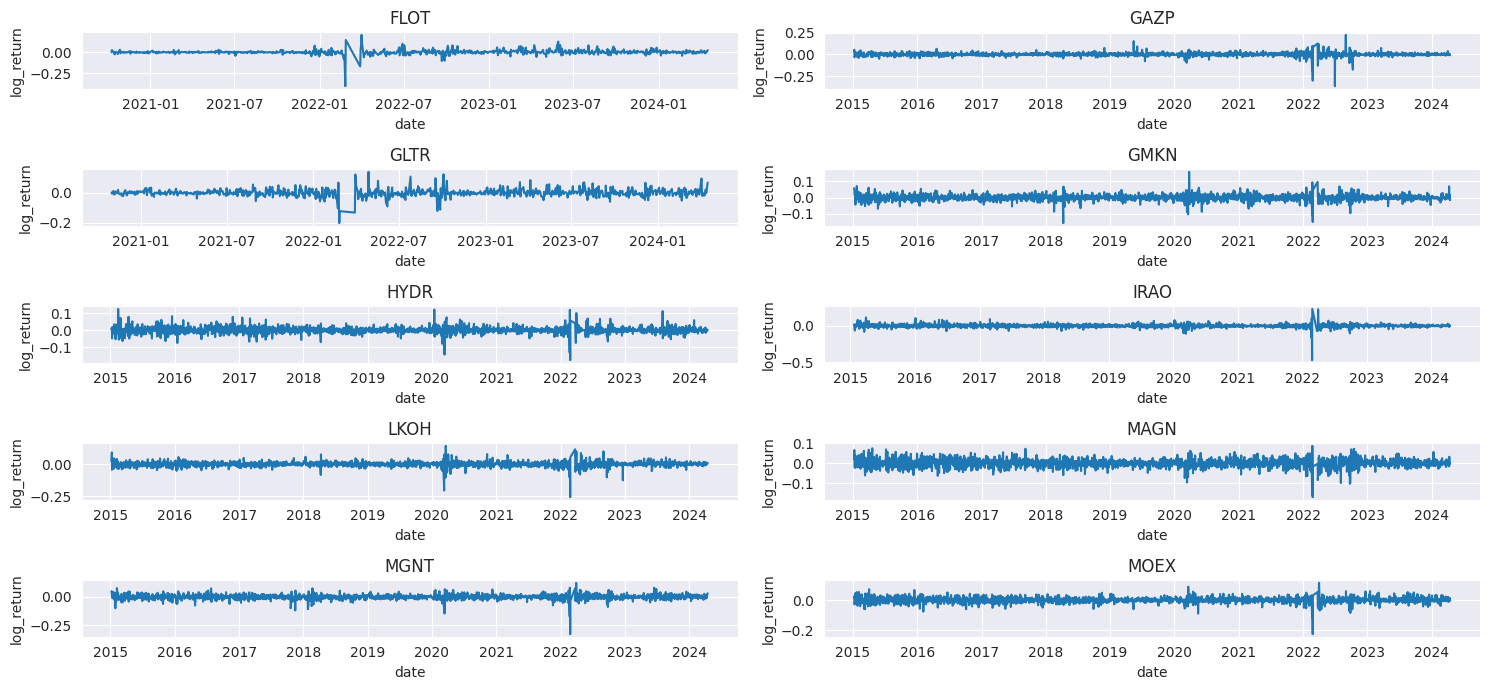

In [5]:
plot_log_returns(df, tickers[10:20])

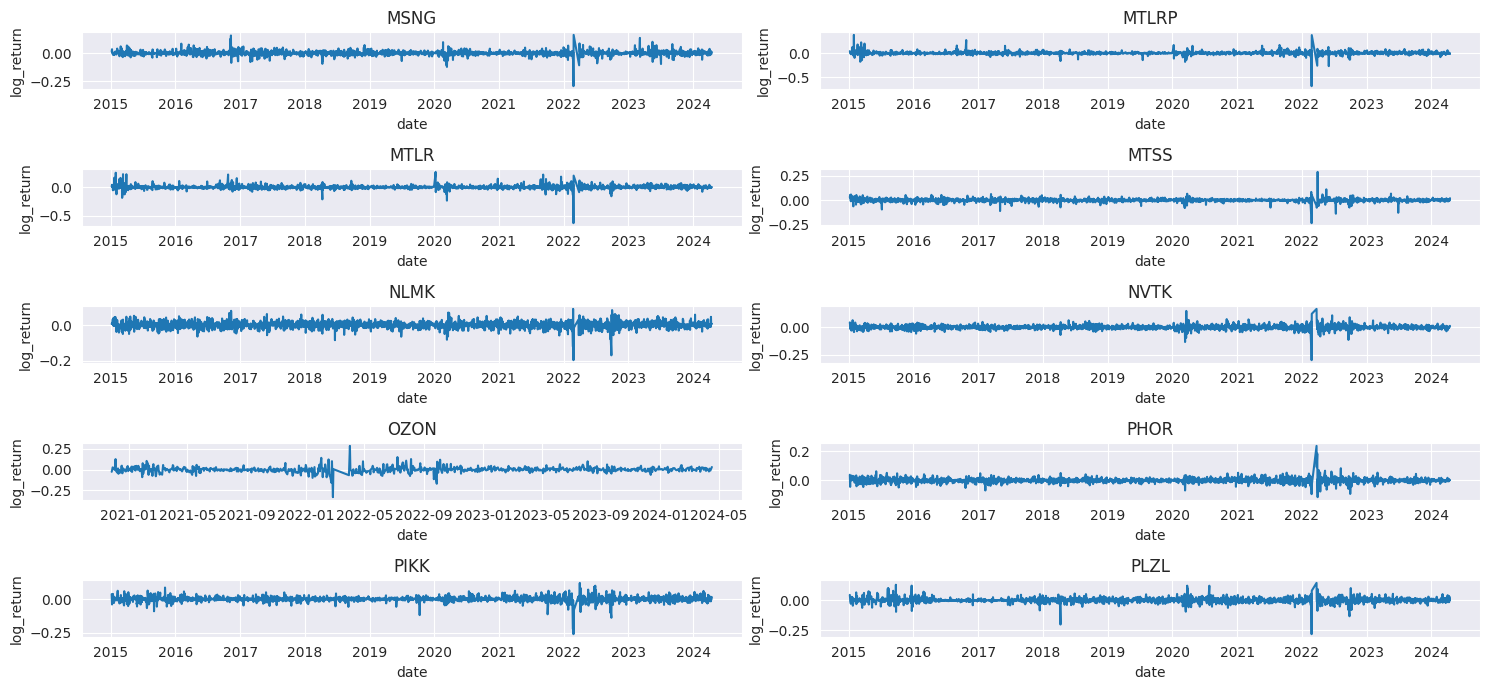

In [6]:
plot_log_returns(df, tickers[20:30])

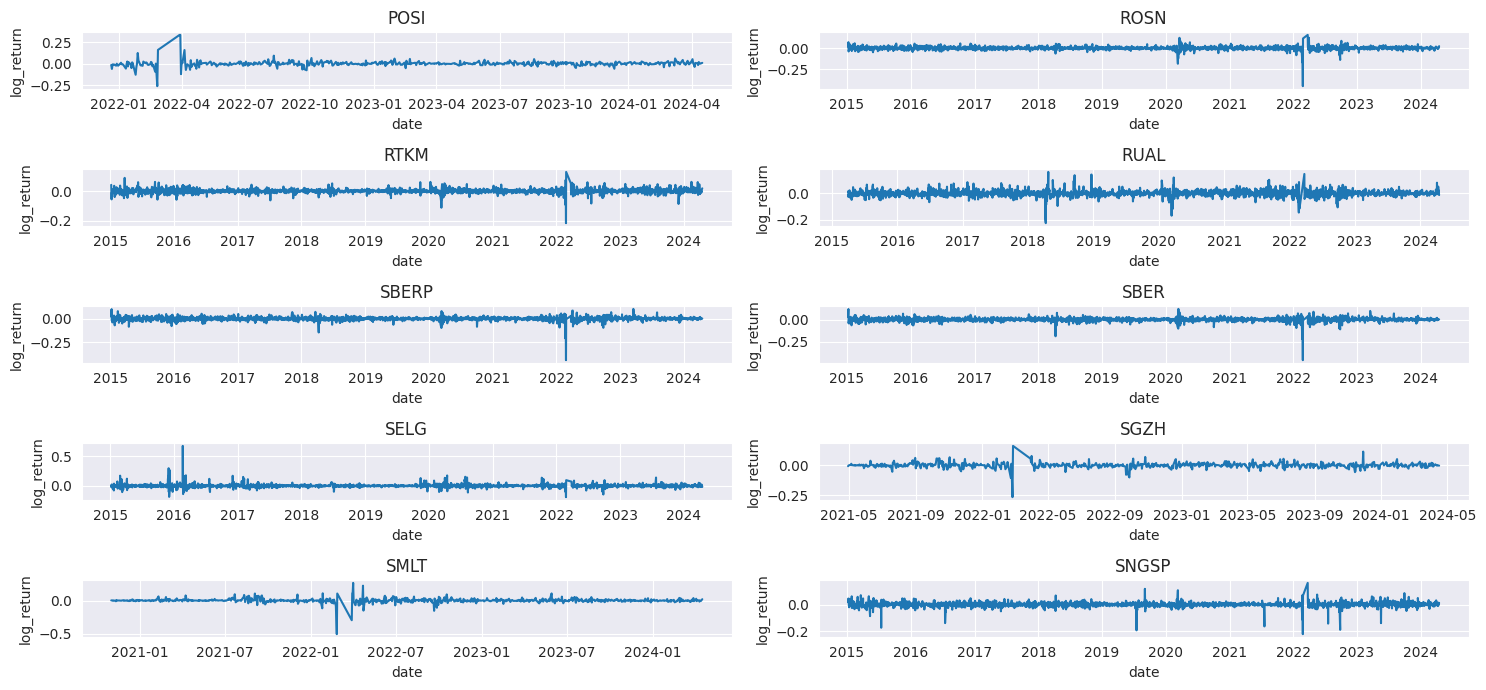

In [7]:
plot_log_returns(df, tickers[30:40])

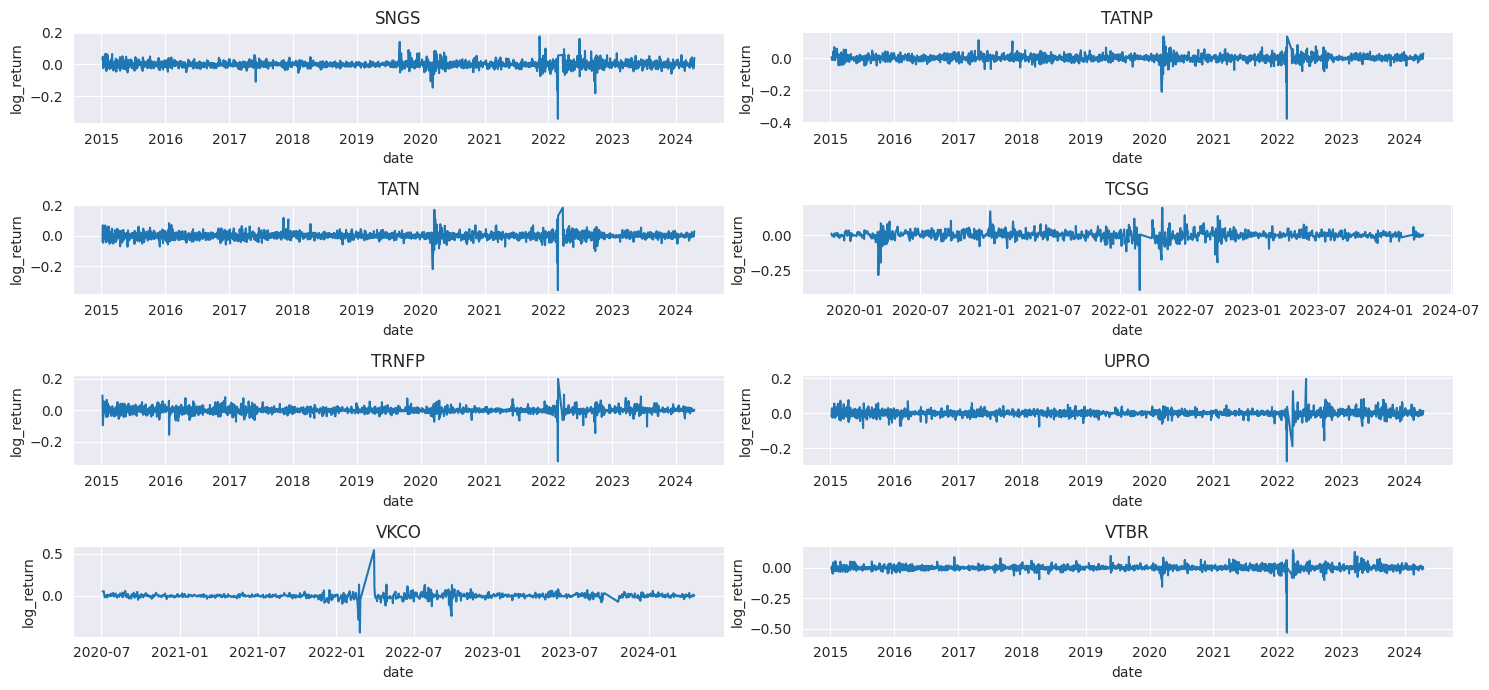

In [8]:
plot_log_returns(df, tickers[40:])

In [28]:
def calculate_volatility_cv_sq(log_returns):
    mean_second_power = np.mean(np.power(log_returns, 2))
    mean_fourth_power = np.mean(np.power(log_returns, 4))
    return mean_fourth_power / (3 * mean_second_power**2) - 1

In [90]:
long_ticker_mask = df.groupby(by="ticker").min()["date"].dt.year < 2020

cv_sq_full = (
    df[["ticker", "log_return"]]
    .groupby(by="ticker")
    .agg(calculate_volatility_cv_sq)
    .rename(columns={"log_return": "vol_cv_squared"})
    .sort_values(by="vol_cv_squared")
)[long_ticker_mask]

cv_sq_part = (
    df.loc[df.date.dt.year < 2020, ["ticker", "log_return"]]
    .groupby(by="ticker")
    .agg(calculate_volatility_cv_sq)
    .rename(columns={"log_return": "vol_cv_squared"})
    .sort_values(by="vol_cv_squared")
)[long_ticker_mask]


/tmp/ipykernel_3348/192460322.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cv_sq_full = (
/tmp/ipykernel_3348/192460322.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cv_sq_part = (


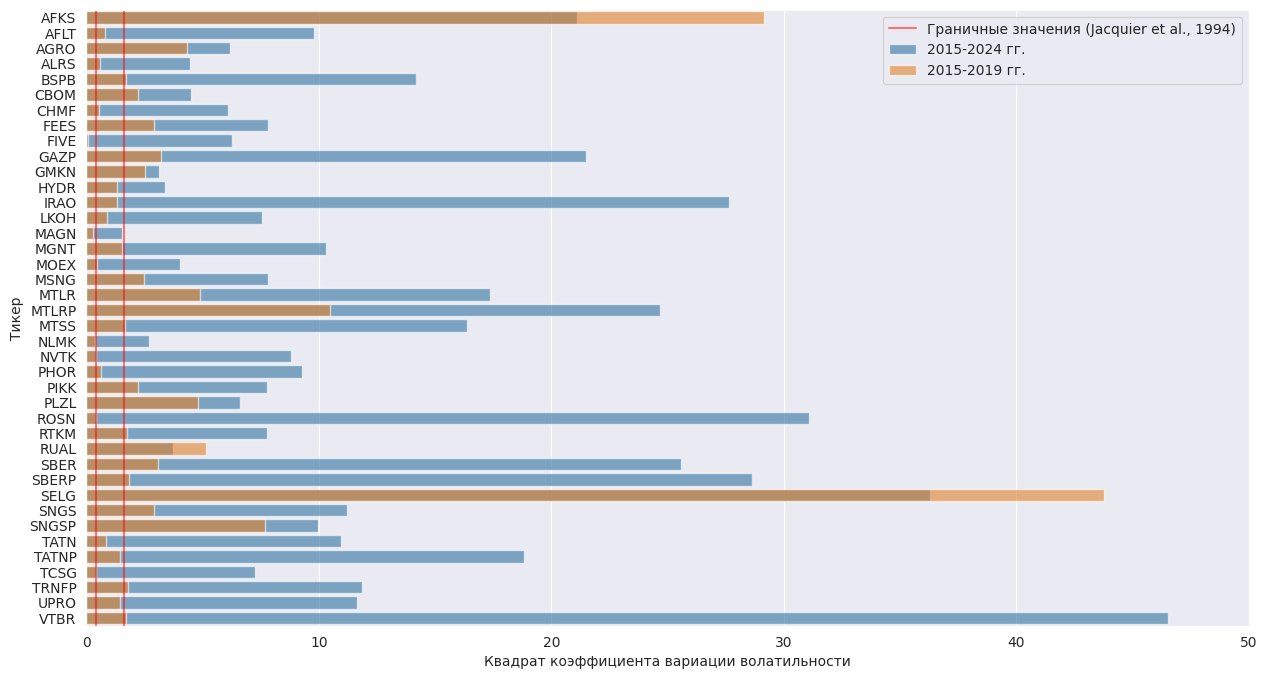

In [110]:
fix, ax = plt.subplots(figsize=(15, 8))

sns.barplot(data=cv_sq_full.sort_index(), y="ticker", x="vol_cv_squared", label="2015-2024 гг.", alpha=0.6);
sns.barplot(data=cv_sq_part.sort_index(), y="ticker", x="vol_cv_squared", label="2015-2019 гг.", alpha=0.6);

ax.set_xlabel("Квадрат коэффициента вариации волатильности")
ax.set_ylabel("Тикер")

ax.axvline(x=0.41, color="red", alpha=0.5, label="Граничные значения (Jacquier et al., 1994)")
ax.axvline(x=1.61, color="red", alpha=0.5)

ax.legend()

ax.set_xlim(0, 50);

plt.savefig("plots/cv_values.svg", format="svg")